<a href="https://colab.research.google.com/github/san-258/QQQ-2-weeks-move/blob/For-any-other-ticker/2_weeks_average_move_of_QQQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This is work to find data - average move - i started with average 2 weeks move of QQQ, got results successfully, might work on few more, i am going to save this is git hub and in branch

 text*

In [1]:
pip install requests pandas numpy matplotlib

In [34]:
from google.colab import userdata
userdata.get('POLYGON_API_KEY')

'OZ72R_JCr3YrDlBarqvG8pOSz_pf8kRY'

In [35]:
pip install requests pandas numpy matplotlib

In [47]:
from google.colab import userdata
# Make sure you have stored your API key in Colab secrets under the name 'POLYGON_API_KEY'
API_KEY = userdata.get('POLYGON_API_KEY')

# Check if the API key was retrieved successfully
if not API_KEY:
    raise ValueError("Polygon API key not found in Colab secrets. Please store it as 'POLYGON_API_KEY'.")

print("API Key retrieved successfully.")

API Key retrieved successfully.


In [48]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

def get_qqq_weekly_moves(api_key, start_date='2024-01-01', end_date='2025-08-18'):
    """
    Calculate average weekly percentage moves for QQQ using Polygon API

    Parameters:
    api_key (str): OZ72R_JCr3YrDlBarqvG8pOSz_pf8kRY
    start_date (str): Start date in YYYY-MM-DD format
    end_date (str): End date in YYYY-MM-DD format

    Returns:
    dict: Analysis results including average moves and statistics
    """

    # Validate API key
    if api_key == "YOUR_POLYGON_API_KEY_HERE" or not api_key:
        raise Exception("Polygon API key is not set. Please provide your actual API key.")

    # Polygon API endpoint for aggregates (bars)
    # Using v2 aggregates endpoint with date range in the path
    # https://polygon.io/docs/stocks/get_v2_aggs_ticker__stocksticker__range__multiplier___timespan___from___to
    url = f"https://api.polygon.io/v2/aggs/ticker/QQQ/range/1/day/{start_date}/{end_date}"

    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'limit': 50000,  # Request a higher limit to get all data within the range
        'apikey': api_key
    }

    print(f"🔍 Attempting to fetch data from: {url}")

    try:
        # Make API request
        response = requests.get(url, params=params)

        # Debug: Print response details
        print(f"📡 Response Status: {response.status_code}")
        print(f"📡 Response Headers: {dict(response.headers)}")

        response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        # Debug: Print response structure
        print(f"📊 Response keys: {list(data.keys())}")
        if 'status' in data:
            print(f"📊 API Status: {data['status']}")

        if data.get('status') != 'OK':
             # Print the full error message from the API response
            error_message = data.get('error', data.get('message', 'Unknown API error'))
            print(f"❌ Full API Response: {data}")
            raise Exception(f"API Error: {error_message}")

        if 'results' not in data or not data['results']:
            print(f"❌ Full API Response: {data}") # Print full response even if results are empty
            # Check if there's a message indicating no data
            if 'message' in data:
                 raise Exception(f"No data returned for the specified date range. API message: {data['message']}")
            else:
                raise Exception(f"No data returned for the specified date range.")


        # Convert to DataFrame
        df = pd.DataFrame(data['results'])
        print(f"📈 Retrieved {len(df)} daily records from {start_date} to {end_date}")

        df['date'] = pd.to_datetime(df['t'], unit='ms')
        df = df.sort_values('date')

        # Calculate weekly data
        df.set_index('date', inplace=True)

        # Resample to weekly data (Friday close to Friday close)
        # Use .ffill() to forward fill NaNs that occur at the start of the week if first day isn't Monday
        weekly_df = df['c'].resample('W-FRI').agg(['first', 'last']).dropna() # Only need open and close for weekly return
        weekly_df.columns = ['o', 'c'] # Rename columns

        # Calculate weekly percentage moves
        # Handle potential division by zero if open is 0
        weekly_df['weekly_return'] = np.where(weekly_df['o'] != 0, ((weekly_df['c'] - weekly_df['o']) / weekly_df['o']) * 100, 0)
        weekly_df['weekly_return_abs'] = abs(weekly_df['weekly_return'])

        # Separate by year
        weekly_df['year'] = weekly_df.index.year

        # Calculate statistics
        results = {}

        # Use the actual years present in the data, not hardcoded 2024, 2025
        years_in_data = sorted(weekly_df['year'].unique())
        print(f"Processing data for years: {years_in_data}")


        for year in years_in_data:
            year_data = weekly_df[weekly_df['year'] == year]

            if len(year_data) > 0:
                results[year] = {
                    'avg_weekly_move': year_data['weekly_return'].mean(),
                    'avg_weekly_move_abs': year_data['weekly_return_abs'].mean(),
                    'median_weekly_move': year_data['weekly_return'].median(),
                    'std_weekly_move': year_data['weekly_return'].std(),
                    'max_weekly_gain': year_data['weekly_return'].max(),
                    'max_weekly_loss': year_data['weekly_return'].min(),
                    'positive_weeks': (year_data['weekly_return'] > 0).sum(),
                    'negative_weeks': (year_data['weekly_return'] < 0).sum(),
                    'total_weeks': len(year_data),
                    'win_rate': (year_data['weekly_return'] > 0).mean() * 100 if len(year_data) > 0 else 0
                }

        # Overall statistics
        if len(weekly_df) > 0:
            results['overall'] = {
                'avg_weekly_move': weekly_df['weekly_return'].mean(),
                'avg_weekly_move_abs': weekly_df['weekly_return_abs'].mean(),
                'median_weekly_move': weekly_df['weekly_return'].median(),
                'std_weekly_move': weekly_df['weekly_return'].std(),
                'max_weekly_gain': weekly_df['weekly_return'].max(),
                'max_weekly_loss': weekly_df['weekly_return'].min(),
                'total_weeks': len(weekly_df),
                'win_rate': (weekly_df['weekly_return'] > 0).mean() * 100 if len(weekly_df) > 0 else 0
            }

        # Return both results and raw data
        data_range_str = "N/A"
        if not weekly_df.empty:
             data_range_str = f"{weekly_df.index.min().strftime('%Y-%m-%d')} to {weekly_df.index.max().strftime('%Y-%m-%d')}"

        return {
            'statistics': results,
            'weekly_data': weekly_df,
            'data_range': data_range_str
        }

    except requests.exceptions.RequestException as e:
        raise Exception(f"Network or API request error: {e}")
    except Exception as e:
        # Catch any other unexpected errors during processing
        raise Exception(f"Error processing data: {e}")


def print_results(results):
    """Print formatted results"""
    print("\n" + "=" * 50)
    print("QQQ Weekly Percentage Move Analysis")
    print("=" * 50)
    print(f"Data Range Analyzed: {results['data_range']}")
    print()

    stats = results['statistics']

    if not stats:
        print("No statistics available for the given date range.")
        return

    # Print overall stats first
    if 'overall' in stats:
        data = stats['overall']
        print(f"\n📊 OVERALL STATISTICS:")
        print(f"   Average Weekly Move: {data['avg_weekly_move']:.2f}%")
        print(f"   Average Absolute Move: {data['avg_weekly_move_abs']:.2f}%")
        print(f"   Median Weekly Move: {data['median_weekly_move']:.2f}%")
        print(f"   Standard Deviation: {data['std_weekly_move']:.2f}%")
        print(f"   Max Weekly Gain: {data['max_weekly_gain']:.2f}%")
        print(f"   Max Weekly Loss: {data['max_weekly_loss']:.2f}%")
        print(f"   Total Weeks: {data['total_weeks']}")
        print(f"   Win Rate: {data['win_rate']:.1f}%")


    # Print yearly stats
    for period, data in stats.items():
        if period != 'overall': # Skip overall as it's printed first
            print(f"\n📅 {period} STATISTICS:")
            print(f"   Average Weekly Move: {data['avg_weekly_move']:.2f}%")
            print(f"   Average Absolute Move: {data['avg_weekly_move_abs']:.2f}%")
            print(f"   Median Weekly Move: {data['median_weekly_move']:.2f}%")
            print(f"   Standard Deviation: {data['std_weekly_move']:.2f}%")
            print(f"   Max Weekly Gain: {data['max_weekly_gain']:.2f}%")
            print(f"   Max Weekly Loss: {data['max_weekly_loss']:.2f}%")
            print(f"   Total Weeks: {data['total_weeks']}")
            print(f"   Win Rate: {data['win_rate']:.1f}%")


def create_visualization(weekly_data, overall_mean):
    """Create simple visualizations of weekly returns"""
    if weekly_data.empty:
        print("No data available for visualization.")
        return

    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Weekly returns over time
        ax1.plot(weekly_data.index, weekly_data['weekly_return'])
        ax1.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        ax1.set_title('QQQ Weekly Returns Over Time')
        ax1.set_ylabel('Weekly Return (%)')
        ax1.grid(True, alpha=0.3)

        # Histogram of weekly returns
        ax2.hist(weekly_data['weekly_return'], bins=30, alpha=0.7, edgecolor='black')
        ax2.axvline(x=overall_mean,
                   color='r', linestyle='--',
                   label=f"Mean: {overall_mean:.2f}%")
        ax2.set_title('Distribution of QQQ Weekly Returns')
        ax2.set_xlabel('Weekly Return (%)')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('qqq_weekly_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("📈 Chart saved as 'qqq_weekly_analysis.png'")

    except Exception as e:
        print(f"Error creating visualization: {e}")

Fetching data for QQQ from 2025-01-01 to 2025-07-31...
🔍 Attempting to fetch data from: https://api.polygon.io/v2/aggs/ticker/QQQ/range/1/day/2025-01-01/2025-07-31
📡 Response Status: 200
📡 Response Headers: {'Date': 'Mon, 18 Aug 2025 20:08:02 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': 'd25e03f86fefaf57f4f64cfc8cb15d77', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}
📊 Response keys: ['ticker', 'queryCount', 'resultsCount', 'adjusted', 'results', 'status', 'request_id', 'count']
📊 API Status: OK
📈 Retrieved 144 daily records from 2025-01-01 to 2025-07-31
Processing data for years: [np.int32(2025)]

QQQ Weekly Percentage Move Analysis
Data Range Analyzed: 2025-01-03 to 2025-08-01


📊 OVERALL STATISTICS:
   Average Weekly Move: 0.29%
   Average Absolute Move: 2.37%
   Median Weekly Move: 0.42%
   Sta

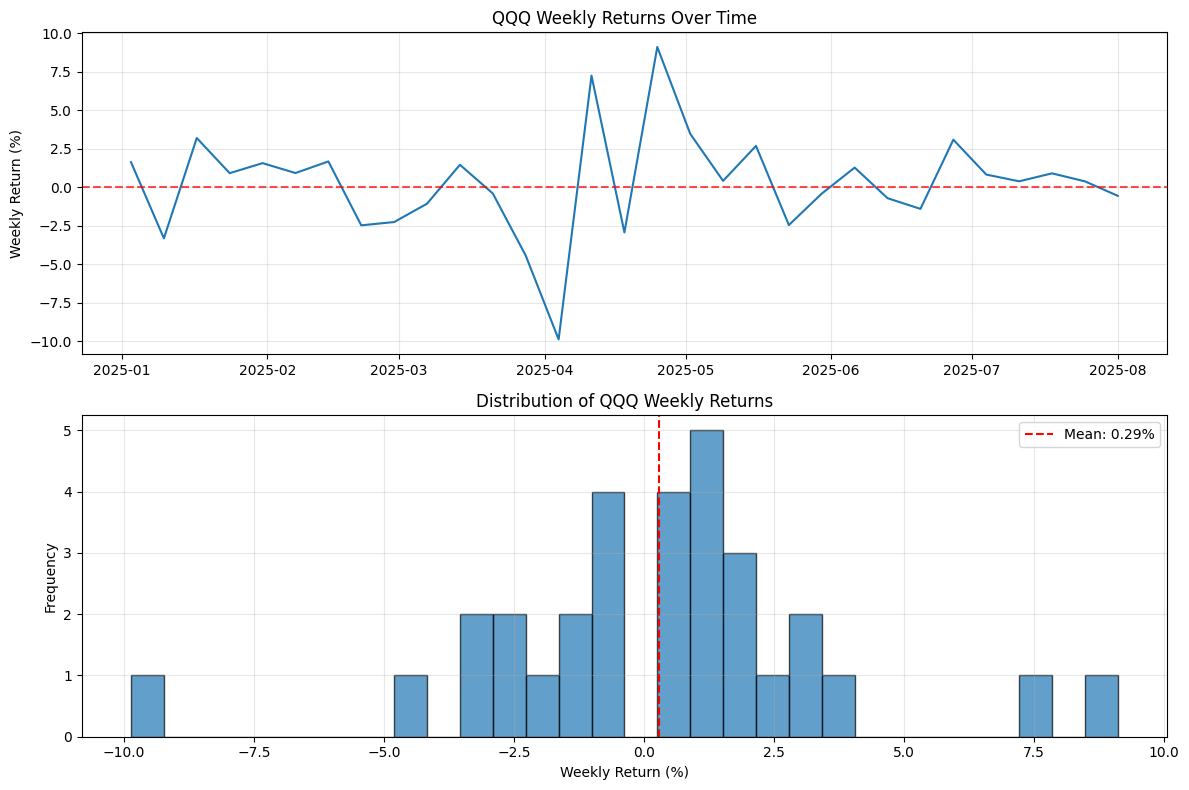

📈 Chart saved as 'qqq_weekly_analysis.png'


In [50]:
# Assuming API_KEY is already defined and contains your Polygon API key
# from running the previous cell that retrieves it from Colab secrets.

try:
    # Define the date range for analysis
    start_date = '2025-01-01'
    end_date = '2025-07-31' # Changed date range as requested

    print(f"Fetching data for QQQ from {start_date} to {end_date}...")

    # Get the analysis results using the get_qqq_weekly_moves function
    # The function is defined in the previous cell (PGtUxSV_obbk)
    results = get_qqq_weekly_moves(API_KEY, start_date=start_date, end_date=end_date)

    # Print the formatted results
    print_results(results)

    # Optional: Save detailed data to CSV
    if not results['weekly_data'].empty:
        results['weekly_data'].to_csv('qqq_weekly_data.csv')
        print(f"\n💾 Detailed weekly data saved to 'qqq_weekly_data.csv'")
    else:
        print("\n Skipping CSV export as no weekly data was generated.")


    # Optional: Create a simple visualization
    if 'overall' in results['statistics']:
        overall_mean_move = results['statistics']['overall']['avg_weekly_move']
        create_visualization(results['weekly_data'], overall_mean_move)
    else:
        print("\n Skipping visualization as no overall statistics were generated.")


except NameError:
    print("Error: API_KEY is not defined. Please run the cell that defines API_KEY first.")
except ValueError as ve:
    print(f"Configuration Error: {ve}")
except Exception as e:
    print(f"An error occurred during analysis: {e}")
    print("\n💡 Troubleshooting steps:")
    print("   - Verify your Polygon API key is correct and stored as 'POLYGON_API_KEY' in Colab secrets.")
    print("   - Check if your API key has access to the required historical data for the specified date range.")
    print("   - Try a smaller, past date range (e.g., '2023-01-01' to '2023-12-31') to test data retrieval.")
    print("   - Consult Polygon API documentation for data availability and endpoint usage.")